# Character Recognition
---
> Image Classification using convolution neural networks. Author: [Pratik Kumar](https://pr2tik1.github.io)<br>Submitted to: [MIDAS Labs](http://midas.iiitd.edu.in)

## Objective

This notebook is divided into three sections with respect to the tasks:

1. Section A :  

> Use this [dataset](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) to train a
CNN. Use no other data source or pretrained networks, and explain your design choices during preprocessing, model building and training. Also, cite the sources you used to
borrow techniques. A test set will be provided later to judge the performance of your
classifier. 

2. Section B:

>Next, select only 0-9 training images from the above dataset, and use the pretrained
network to train on MNIST dataset. Use the standard MNIST train and test splits
(http://yann.lecun.com/exdb/mnist/). How does this pretrained network perform in
comparison to a randomly initialized network in terms of convergence time, final
accuracy and other possible training quality metrics? Do a thorough analysis. 

3. Section C: 

>Finally, take the following dataset
(https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip), train on this dataset and
provide test accuracy on the MNIST test set, using the same test split from part 2. Train
using scratch random initialization and using the pretrained network part 1. Do the same
analysis as 2 and report what happens this time. Try and do qualitative analysis of what's
different in this dataset. 

# Section A: **Character Images Classification**
---

## A.1. Importing Modules

To develop and train a convolution neural network architecture, I have used PyTorch framework. Along with this OpenCV, numpy, pandas and matplotlib for image data handling and plotting are used. In this section we will importing all necessary modules.  

In [2]:
import random
import copy
import time 
import pandas as pd 
from PIL import Image
from torchsummary import summary


import torch
import torchvision
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
from data import dataset
from plotting import plot_loss, plot_images
from model import Net
from train import train_model, compute_accuracy, cal_accuracy

## A.2. Data Preprocessing

The initial step is to create a dataframe of labels generated by carefully examining the dataset provided. This Labels.csv is mapped to image with its corresponding labels. This is necessary step for our model to understand classes. PyTorch also provides torchvision.data.ImageFolder() function to   

To change images into vector with normalisation and augmentation, following values are fetched to torchvision.transforms function. We perform: 
    
    - Random Rotations
    - Random Resizing and Cropping 
    - Change Image arrays to Tensor
    - Normalize

In [4]:
train_transforms = transforms.Compose([
                   transforms.RandomRotation(degrees=45),
                   transforms.RandomResizedCrop(64, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
                   transforms.ToTensor(),
                   transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])

               ])

Loading custom dataset that returns images and labels. 

In [5]:
LABELS='data/labels.csv' 
ROOT = 'data/train'

train_data = dataset(csv=LABELS, img_path=ROOT, transform = train_transforms)

In [6]:
df=pd.read_csv('data/labels.csv' )
df.head()

,filenames,labels_code,labels
0,img001-001.png,img001,0
1,img001-002.png,img001,0
2,img001-003.png,img001,0
3,img001-004.png,img001,0
4,img001-007.png,img001,0


Splitting the dataset into training and validation dataset. This is needed to keep track of how our model performs.

In [7]:
VALID_RATIO = 0.75
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data,[n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = train_transforms

The final number of training and validation dataset.

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 1860
Number of validation examples: 620


Further we take our tensor datasets and put fetch them into Dataloader with certain batches(BATCH_SIZE). 

In [9]:
BATCH_SIZE = 256
train_iterator = data.DataLoader(train_data,batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data,batch_size = BATCH_SIZE)

## A.3. Images
Following are the images after preprocessing steps. The images are of (1200 x 900)px initially, but are processed to (64 x 64)px size and Rotated to 45 degrees. Since the images are png images they have 3 channels.

In [10]:
img_pil = Image.open('data/train/img001-001.png')
print('Image Channels and Size: ', img_pil.mode, img_pil.size)

Image Channels and Size:  RGB (1200, 900)


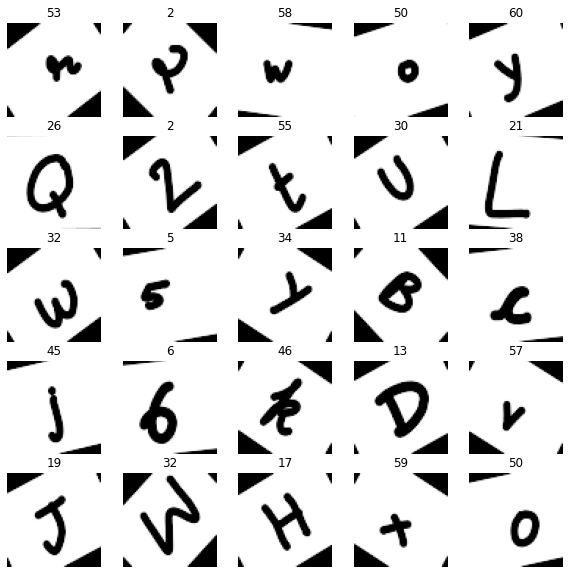

In [11]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])
classes = list(df['labels'].unique())
plot_images(images, labels, classes)

## A.4. Hyper-parameters and model development

In this section setting device to cuda or cpu based upon availablity. Loading the model and setting hyper parameters for training. I have used Cross Entropy loss function which is suitable for multi-class classification tasks. The classes in our task is 10+26+26=62 classes, as we have digits, small letters and capital letters. The updation rule is Adam optimizer with learning rate of 1e-4.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 100
model = Net(62)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device

device(type='cuda')

Our model is inspired by AlexNet which was among the early CNNs that performed well in ImageNet Classification Challenge. This has 8 layers: 5 Convolution Layers and 3 Fully Connected Layers. The input to intital convolution layer is 64x64x3 image that are processed into arrays with values ranging from 0 to 1. Final output layer after series of convolution, pooling, and drop outs, yield predictions for the 62 classes.  

In [13]:
model

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

Following is summary of model. One can notice the size of the model and number of parameters.

In [14]:
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

## A.5. Training the custom model Net()

Training the model on the character images dataset. This block trains the model and saves it as 'model.pt' in same directory. The train_model function returns lists of training and validation accuracies and as well as the losses. The total epochs are set to 60, taking care of underfitting and overfitting.  

In [15]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = train_model(model=model, #model from scratch 
                                             num_epochs=num_epochs,
                                             train_iterator=train_iterator,
                                             valid_iterator=valid_iterator, 
                                             optimizer=optimizer,
                                             criterion=criterion, 
                                             device=device,
                                             model_name='model.pt')

Epoch: 1 	Training Loss: 0.017758 	Validation Loss: 0.019984
Validation loss decreased (inf --> 0.019984).  Saving model ...
Epoch: 2 	Training Loss: 0.017741 	Validation Loss: 0.020016
Epoch: 3 	Training Loss: 0.017711 	Validation Loss: 0.020106
Epoch: 4 	Training Loss: 0.017664 	Validation Loss: 0.019983
Validation loss decreased (0.019984 --> 0.019983).  Saving model ...
Epoch: 5 	Training Loss: 0.017473 	Validation Loss: 0.019902
Validation loss decreased (0.019983 --> 0.019902).  Saving model ...
Epoch: 6 	Training Loss: 0.017264 	Validation Loss: 0.019455
Validation loss decreased (0.019902 --> 0.019455).  Saving model ...
Epoch: 7 	Training Loss: 0.017050 	Validation Loss: 0.019282
Validation loss decreased (0.019455 --> 0.019282).  Saving model ...
Epoch: 8 	Training Loss: 0.016997 	Validation Loss: 0.019118
Validation loss decreased (0.019282 --> 0.019118).  Saving model ...
Epoch: 9 	Training Loss: 0.016791 	Validation Loss: 0.018910
Validation loss decreased (0.019118 --> 0.

## A.6. Plotting Loss and Accuracy of model

The lists from the above train_model function are visualized below.

### A.6.1. Loss Curve

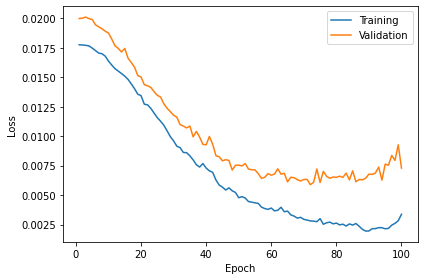

In [16]:
plot_loss(train_loss_list, valid_loss_list)

### A.6.2. Accuracy Curve

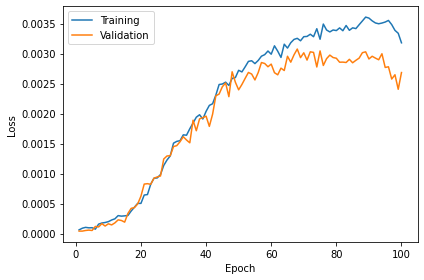

In [17]:
plot_loss(train_acc_list, valid_acc_list)

## A.7. Calculate accuracy

The training and validation accuracy is calculated in this block to keep track of how oue model performs.

In [18]:
print('Training: ', cal_accuracy(train_iterator, model, device))

Got 1412 / 1860 with accuracy 75.91
Training:  None


In [19]:
print('Validation: ',cal_accuracy(valid_iterator, model, device))

Got 356 / 620 with accuracy 57.42
Validation:  None


# Section B: **Digit Recognition** 
---
In this section we have to train oure pretrained model over the images of digits in the range 0-9 from the same dataset as above. This is transfer learning on new set of outputs. Our objective is to understand how the model works in this scenario.

In [20]:
NEW_LABELS = 'data/digit_labels.csv'
train_numbers = dataset(csv=NEW_LABELS, img_path=ROOT, transform = train_transforms)

VALID_RATIO = 0.83 #Stamdard split according to (http://yann.lecun.com/exdb/mnist/).
n_train_examples = int(len(train_numbers) * VALID_RATIO)
n_valid_examples = len(train_numbers) - n_train_examples
train_num_data, valid_num_data = data.random_split(train_numbers, [n_train_examples, n_valid_examples])

valid_num_data = copy.deepcopy(valid_num_data)
valid_num_data.dataset.transform = train_transforms

print(f'Number of training examples: {len(train_num_data)}')
print(f'Number of validation examples: {len(valid_num_data)}')

Number of training examples: 332
Number of validation examples: 68


In [21]:
train_num_iterator = data.DataLoader(train_num_data, batch_size = 8)
valid_num_iterator = data.DataLoader(valid_num_data, batch_size = 8)

## B.3. Trained Model

In [22]:
model_trained = Net(62)
model_trained.load_state_dict(torch.load('./model.pt'))
model_trained.train()

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

While using pretrained model we have to make sure that the last layers match the output to number of classes. The number of classes is changed from 62 to 10 digits. Thus I have changed the last fully connected layer as follows,

In [23]:
model_trained.classifier[4] = torch.nn.Linear(4096,1024)
model_trained.classifier[6] = torch.nn.Linear(1024,10)

## B.3.1. Hyperparameters for pretrained model

- Cross Entropy Loss : Because multi class classification
- Stochastic Gradient Descent : Optimizer Function
- Learning rate : 0.001

In [24]:
model_trained.to(device)
criterion_num = torch.nn.CrossEntropyLoss()
optimizer_num = torch.optim.SGD(model_trained.parameters(), lr=0.001)
device

device(type='cuda')

In [25]:
model_trained

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

## B.4. Training the pretrained model

The model is trained for only 20 epochs to save it from overfitting. 

In [26]:
train_loss_digits, valid_loss_digits, train_acc_digits, valid_acc_digits = train_model(model=model_trained, #pretrained model from section B.3.
                                             num_epochs=20,
                                             train_iterator=train_num_iterator,
                                             valid_iterator=valid_num_iterator, 
                                             optimizer=optimizer_num,
                                             criterion=criterion_num, 
                                            device=device, model_name="model_1.pt")

Epoch: 1 	Training Loss: 0.266394 	Validation Loss: 0.234393
Validation loss decreased (inf --> 0.234393).  Saving model ...
Epoch: 2 	Training Loss: 0.203142 	Validation Loss: 0.160883
Validation loss decreased (0.234393 --> 0.160883).  Saving model ...
Epoch: 3 	Training Loss: 0.146046 	Validation Loss: 0.103641
Validation loss decreased (0.160883 --> 0.103641).  Saving model ...
Epoch: 4 	Training Loss: 0.104443 	Validation Loss: 0.093944
Validation loss decreased (0.103641 --> 0.093944).  Saving model ...
Epoch: 5 	Training Loss: 0.086875 	Validation Loss: 0.063734
Validation loss decreased (0.093944 --> 0.063734).  Saving model ...
Epoch: 6 	Training Loss: 0.081074 	Validation Loss: 0.060815
Validation loss decreased (0.063734 --> 0.060815).  Saving model ...
Epoch: 7 	Training Loss: 0.075107 	Validation Loss: 0.051354
Validation loss decreased (0.060815 --> 0.051354).  Saving model ...
Epoch: 8 	Training Loss: 0.065035 	Validation Loss: 0.055414
Epoch: 9 	Training Loss: 0.059853 

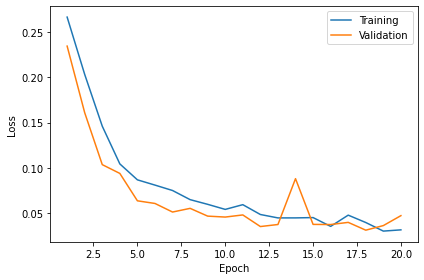

In [27]:
plot_loss(train_loss_digits, valid_loss_digits)

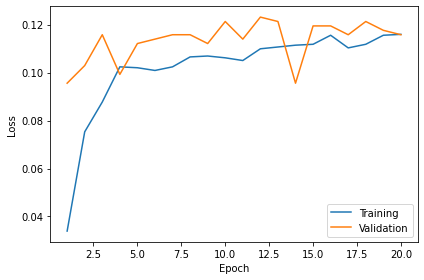

In [28]:
plot_loss(train_acc_digits, valid_acc_digits)

In [29]:
cal_accuracy(train_num_iterator, model_trained, device)

Got 316 / 332 with accuracy 95.18


In [30]:
cal_accuracy(valid_num_iterator, model_trained, device)

Got 62 / 68 with accuracy 91.18


## B.5. Model Scratch training on Digits 

In [31]:
model_digits = Net(10)
model_digits

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [32]:
model_digits.to(device)
criterion_digits= torch.nn.CrossEntropyLoss()
optimizer_digits = torch.optim.SGD(model_digits.parameters(), lr=0.001)
device

device(type='cuda')

In [33]:
tr_loss, val_loss, tr_acc, val_acc = train_model(model=model_digits, #model from scratch 
                                             num_epochs=20,
                                             train_iterator=train_num_iterator,
                                             valid_iterator=valid_num_iterator, 
                                             optimizer=optimizer_num,
                                             criterion=criterion_num, 
                                            device=device, model_name="model_2.pt")

Epoch: 1 	Training Loss: 0.291300 	Validation Loss: 0.304940
Validation loss decreased (inf --> 0.304940).  Saving model ...
Epoch: 2 	Training Loss: 0.291308 	Validation Loss: 0.304947
Epoch: 3 	Training Loss: 0.291278 	Validation Loss: 0.304948
Epoch: 4 	Training Loss: 0.291279 	Validation Loss: 0.304944
Epoch: 5 	Training Loss: 0.291262 	Validation Loss: 0.304950
Epoch: 6 	Training Loss: 0.291269 	Validation Loss: 0.304946
Epoch: 7 	Training Loss: 0.291308 	Validation Loss: 0.304950
Epoch: 8 	Training Loss: 0.291255 	Validation Loss: 0.304948
Epoch: 9 	Training Loss: 0.291306 	Validation Loss: 0.304949
Epoch: 10 	Training Loss: 0.291270 	Validation Loss: 0.304950
Epoch: 11 	Training Loss: 0.291281 	Validation Loss: 0.304945
Epoch: 12 	Training Loss: 0.291235 	Validation Loss: 0.304945
Epoch: 13 	Training Loss: 0.291312 	Validation Loss: 0.304947
Epoch: 14 	Training Loss: 0.291270 	Validation Loss: 0.304947
Epoch: 15 	Training Loss: 0.291247 	Validation Loss: 0.304954
Epoch: 16 	Trai

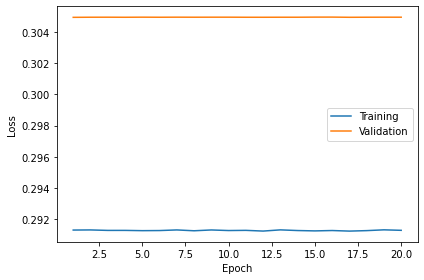

In [34]:
plot_loss(tr_loss, val_loss)

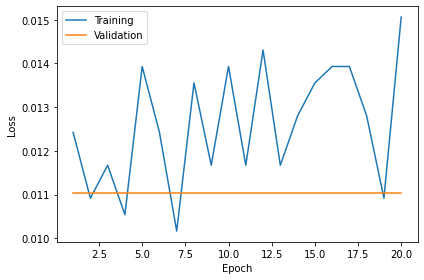

In [35]:
plot_loss(tr_acc, val_acc)

In [36]:
print("Train:", cal_accuracy(train_num_iterator, model_digits, device))
print("Valid:", cal_accuracy(valid_num_iterator, model_digits, device))

Got 34 / 332 with accuracy 10.24
Train: None
Got 6 / 68 with accuracy 8.82
Valid: None


## B.5. Conclusion

In this section we notice that model works better than before. This is because the same model has already 'learned' the features, i.e. the weights. In the pretrained case we observe accuracies around 92 percent for training and 89 percent for testing. But in case of scratch model trained on digits with same hyper parameters we observe poor performance. 

# Section C: Digit Images Classification on different dataset
---

## C.1. Loading data and model 

In [37]:
data_folder = '../input/task3/mnistTask'
new_data = datasets.ImageFolder(root = data_folder, transform=train_transforms)

In [38]:
VALID_RATIO = 0.83
new_train_data = int(len(new_data) * VALID_RATIO)
new_valid_data = len(new_data) - new_train_data
train, valid = data.random_split(new_data, [new_train_data, new_valid_data])

valid = copy.deepcopy(valid)
valid.dataset.transform = train_transforms

print(f'Number of training examples: {len(train)}')
print(f'Number of validation examples: {len(valid)}')

Number of training examples: 49800
Number of validation examples: 10200


In [39]:
train_loader = data.DataLoader(train, batch_size = 256)
valid_loader = data.DataLoader(valid, batch_size = 256)

In [40]:
model_scratch = Net(10)
model_scratch.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_scratch.parameters(), lr=1e-4)
device

device(type='cuda')

In [41]:
model_scratch

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

## C.2. Training Model from scratch

In [42]:
train_loss_scratch, valid_loss_scratch, train_acc_scratch, valid_acc_scratch = train_model(model=model_scratch, #Scratch model 
                                                                                 num_epochs=30,
                                                                                 train_iterator=train_loader,
                                                                                 valid_iterator=valid_loader, 
                                                                                 optimizer=optimizer,
                                                                                 criterion=criterion, 
                                                                                device=device, model_name="model_scratch.pt")

Epoch: 1 	Training Loss: 0.009016 	Validation Loss: 0.009024
Validation loss decreased (inf --> 0.009024).  Saving model ...
Epoch: 2 	Training Loss: 0.008993 	Validation Loss: 0.008992
Validation loss decreased (0.009024 --> 0.008992).  Saving model ...
Epoch: 3 	Training Loss: 0.008968 	Validation Loss: 0.008955
Validation loss decreased (0.008992 --> 0.008955).  Saving model ...
Epoch: 4 	Training Loss: 0.008909 	Validation Loss: 0.008892
Validation loss decreased (0.008955 --> 0.008892).  Saving model ...
Epoch: 5 	Training Loss: 0.008859 	Validation Loss: 0.008839
Validation loss decreased (0.008892 --> 0.008839).  Saving model ...
Epoch: 6 	Training Loss: 0.008803 	Validation Loss: 0.008783
Validation loss decreased (0.008839 --> 0.008783).  Saving model ...
Epoch: 7 	Training Loss: 0.008762 	Validation Loss: 0.008773
Validation loss decreased (0.008783 --> 0.008773).  Saving model ...
Epoch: 8 	Training Loss: 0.008749 	Validation Loss: 0.008770
Validation loss decreased (0.00877

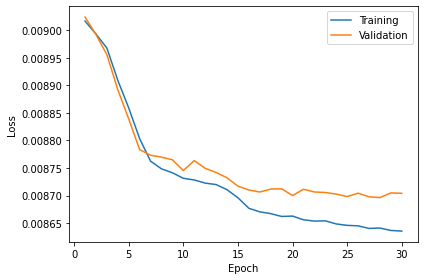

In [43]:
plot_loss(train_loss_scratch, valid_loss_scratch)

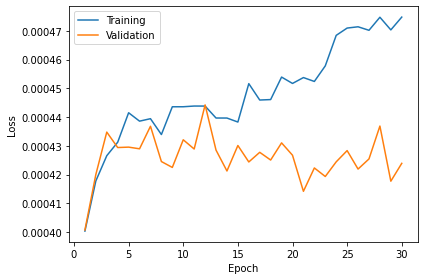

In [44]:
plot_loss(train_acc_scratch, valid_acc_scratch)

In [45]:
print(cal_accuracy(train_loader, model_scratch, device))

Got 6181 / 49800 with accuracy 12.41
None


In [46]:
print(cal_accuracy(valid_loader, model_scratch, device))

Got 1090 / 10200 with accuracy 10.69
None


## C.3. Training the pretrained model (on mnistTask3 dataset)


In [47]:
model_trained 

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [48]:
train_loss_, valid_loss_, train_acc_, valid_acc_ = train_model(model=model_trained, #Pretrained model from section B.3.
                                                                                 num_epochs=num,
                                                                                 train_iterator=train_loader,
                                                                                 valid_iterator=valid_loader, 
                                                                                 optimizer=optimizer,
                                                                                 criterion=criterion, 
                                                                                device=device, model_name="model_pretr.pt")

NameError: name 'num' is not defined

In [49]:
plot_loss(train_loss_, train_loss_)

NameError: name 'train_loss_' is not defined

In [50]:
plot_loss(train_acc_, valid_acc_)

NameError: name 'train_acc_' is not defined

In [51]:
print(cal_accuracy(train_loader, model_trained, device))

Got 4966 / 49800 with accuracy 9.97
None


In [52]:
print(cal_accuracy(train_loader, model_trained, device))

Got 4968 / 49800 with accuracy 9.98
None


# The END!